### Kritik Bulgular: Korelasyon Yanılgısı
En alttaki grafikte görüyoruz ki V10 aslında fraud riskini artıran önemli özelliklerden biri.

V10 u, **01_EDA** dosyasında incelediğimizde class ile korelasyonu çok düşük çıktığı için **bağımsız** olabileceğini düşünmüştük ama anlıyoruz ki bir değişkenin hedef değişkenle korelasyonunun **düşük** çıkması tamamen bağımsız olduğu anlamına gelmiyor.

V10, modelin yakaladığı **non-lineer** ilişkilerde veya diğer değişkenlerle kurduğu **etkileşimlerde** kritik bir rol oynamaktadır.

In [93]:
import shap

In [94]:
import pandas as pd

In [95]:
import joblib

In [96]:
import numpy as np

In [97]:
from sklearn.metrics import ndcg_score

In [98]:
import matplotlib.pyplot as plt
import lightgbm as lgb

In [122]:
from sklearn.metrics import roc_auc_score

In [99]:
shap.initjs()

In [100]:
test_df = pd.read_csv('../data/ranking/test.csv')

In [101]:
q_test = test_df.groupby('Event_Block', sort=False).size().to_list()

In [102]:
X_test = test_df.drop(['Class', 'Time','Event_Block'], axis=1)
y_test = test_df['Class']

In [105]:
model = joblib.load('../models/lgbm_ranker.pkl')

In [106]:
y_pred = model.predict(X_test)

[LightGBM] [Warning] lambda_l1 is set=0.10660088294024428, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.10660088294024428
[LightGBM] [Warning] feature_fraction is set=0.9326918410538783, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9326918410538783
[LightGBM] [Warning] bagging_fraction is set=0.5429073696880456, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5429073696880456
[LightGBM] [Warning] lambda_l2 is set=4.157067925555031, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.157067925555031


/Users/pinar/fraud-detection-bootcamp/venv/lib/python3.13/site-packages/lightgbm/sklearn.py:861: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


In [107]:
def calculate_mean_ndcg(df, preds, k=10):
    df['score'] = preds
    ndcg_values = []
    
    for block_id, group in df.groupby('Event_Block'):
        if group['Class'].sum() == 0:
            continue 
            
        # Sklearn ndcg_score formati: (y_true, y_score) -> boyutlari (1, n_samples) olmali
        true_relevance = [group['Class'].values]
        predicted_scores = [group['score'].values]
        
        score = ndcg_score(true_relevance, predicted_scores, k=k)
        ndcg_values.append(score)
        
    return np.mean(ndcg_values)

In [108]:
final_ndcg = calculate_mean_ndcg(test_df, y_pred, k=10)
baseline_auc = 0.886

In [109]:
comparison = pd.DataFrame({
    'Model': ['Baseline (LGBM Classifier)', 'Final (LGBM Ranker)'],
    'Metric Type': ['Classification (Genel Doğruluk)', 'Ranking (Sıralama Başarısı)'],
    'Metric Name': ['ROC-AUC', 'NDCG@10'],
    'Score': [baseline_auc, final_ndcg]
})

In [110]:
print(comparison)

                        Model                      Metric Type Metric Name  \
0  Baseline (LGBM Classifier)  Classification (Genel Doğruluk)     ROC-AUC   
1         Final (LGBM Ranker)      Ranking (Sıralama Başarısı)     NDCG@10   

      Score  
0  0.886000  
1  0.848047  


In [123]:
final_auc = roc_auc_score(y_test, y_pred)

print(f"Baseline ROC-AUC: {baseline_auc}")
print(f"Final Ranker ROC-AUC: {final_auc}")

Baseline ROC-AUC: 0.886
Final Ranker ROC-AUC: 0.9855062418580333


<Figure size 1000x500 with 0 Axes>

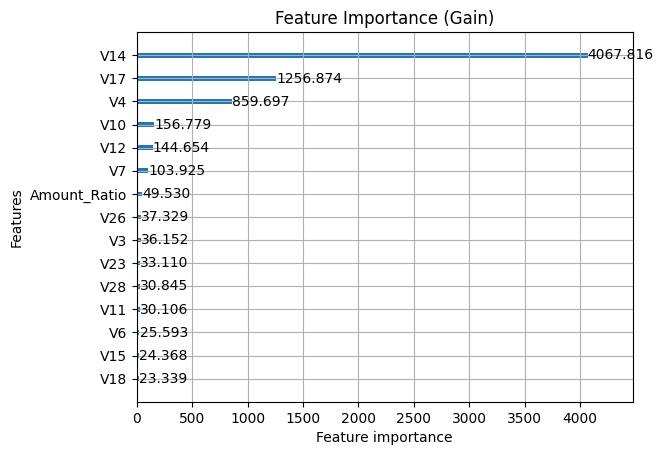

In [111]:
plt.figure(figsize=(10, 5))
lgb.plot_importance(model, max_num_features=15, importance_type='gain', title='Feature Importance (Gain)')
plt.show()

In [112]:
explainer = shap.TreeExplainer(model)

In [113]:
shap_values = explainer.shap_values(X_test.iloc[:1000])

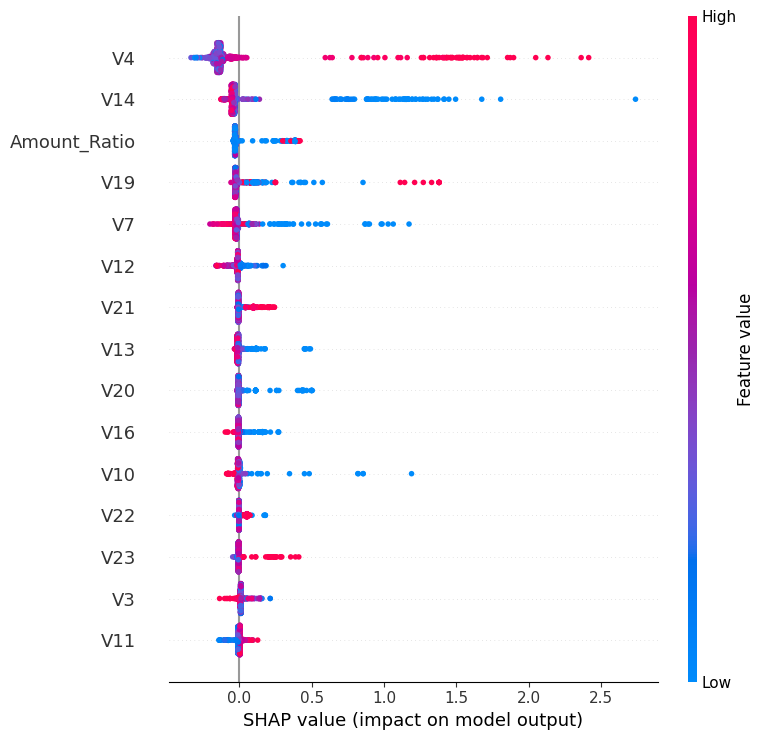

In [114]:
plt.figure()
shap.summary_plot(shap_values, X_test.iloc[:1000], max_display=15)

In [117]:
fraud_indices = y_test[y_test == 1].index
sample_idx = fraud_indices[0] #ilk dolandiriciyi seciyoruz

In [119]:
print(f"İncelenen İşlem İndeksi: {sample_idx}")
print(f"Gerçek Durum: Fraud (1)")
print(f"Model Skoru: {y_pred[sample_idx]:.4f}")

İncelenen İşlem İndeksi: 1949
Gerçek Durum: Fraud (1)
Model Skoru: 3.9404


**Ranker olduğu için 1 den büyük değer verebiliyor.**

In [120]:
explainer_obj = shap.TreeExplainer(model)
shap_val_single = explainer_obj(X_test.iloc[[sample_idx]])

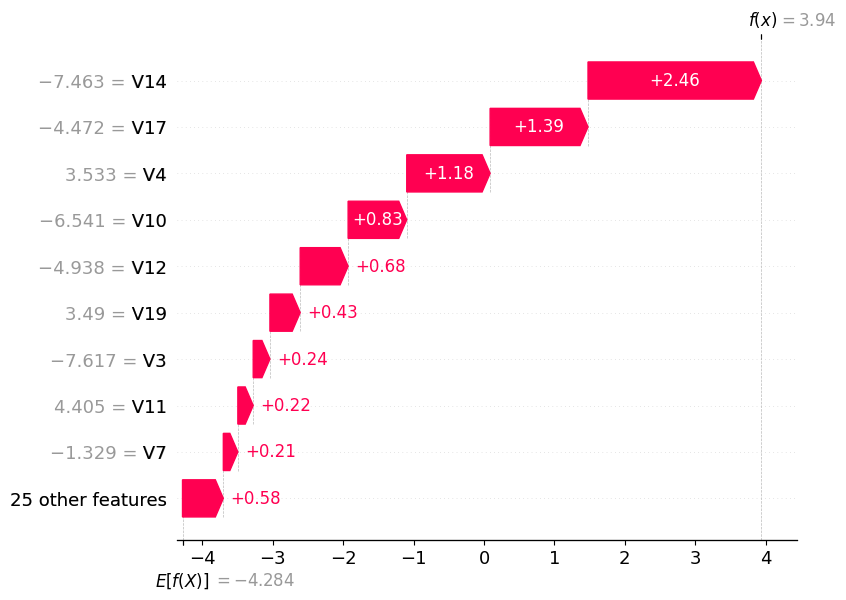

In [121]:
plt.figure()
shap.plots.waterfall(shap_val_single[0])